### 语言模型和数据集


1. 学习语言模型

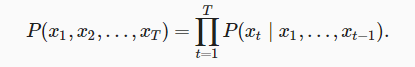

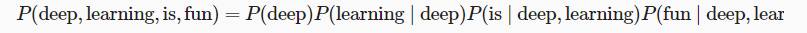

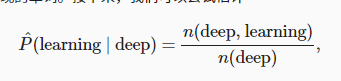

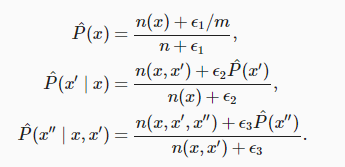

2. 马尔可夫模型与 n 元语法


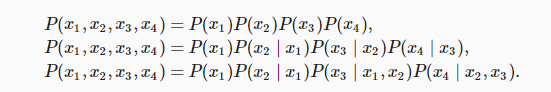

3. 自然语言统计
4. 读取长序列数据:分割文本时，不同的偏移量会导致不同的子序列
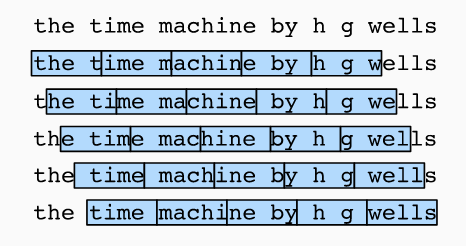

 * 随机采样
 * 顺序分区
5. 小结

In [1]:
import random
import torch
import d2l


tokens = d2l.tokenize(d2l.read_time_machine())
# 因为每个文本行不一定是一个句子或一个段落，因此我们把所有文本行拼接到一起
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

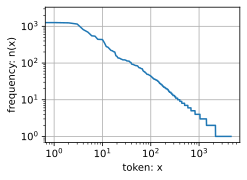

In [2]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',xscale='log', yscale='log')

In [3]:
# 二元法
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [4]:
# 三元法
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

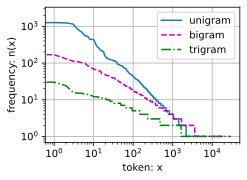

In [5]:
# 一元语法、二元语法和三元语法比较
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

In [20]:

# 随机采样
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列。"""
    # 从随机偏移量开始对序列进行分区，随机范围包括`num_steps - 1`
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为`num_steps`的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从`pos`位置开始的长度为`num_steps`的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，`initial_indices`包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [21]:

my_seq = list(range(35))

for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)


X:  tensor([[16, 17, 18, 19, 20],
        [ 1,  2,  3,  4,  5]]) 
Y: tensor([[17, 18, 19, 20, 21],
        [ 2,  3,  4,  5,  6]])
X:  tensor([[ 6,  7,  8,  9, 10],
        [21, 22, 23, 24, 25]]) 
Y: tensor([[ 7,  8,  9, 10, 11],
        [22, 23, 24, 25, 26]])
X:  tensor([[26, 27, 28, 29, 30],
        [11, 12, 13, 14, 15]]) 
Y: tensor([[27, 28, 29, 30, 31],
        [12, 13, 14, 15, 16]])


In [22]:
# 使用顺序分区生成一个小批量子序列。
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列。"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [23]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 3,  4,  5,  6,  7],
        [18, 19, 20, 21, 22]]) 
Y: tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]])
X:  tensor([[ 8,  9, 10, 11, 12],
        [23, 24, 25, 26, 27]]) 
Y: tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]])
X:  tensor([[13, 14, 15, 16, 17],
        [28, 29, 30, 31, 32]]) 
Y: tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]])


In [27]:
# 现在，我们将上面的两个采样函数包装到一个类中，以便稍后可以将其用作数据迭代器。
class SeqDataLoader: 
    """加载序列数据的迭代器。"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [28]:
# 它同时返回数据迭代器和词汇表
def load_data_time_machine(batch_size, num_steps,use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词汇表。"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [36]:
batch_size,num_steps=2,10
a = load_data_time_machine(batch_size=batch_size,num_steps=num_steps)[1]
a.token_to_idx

{'<unk>': 0,
 ' ': 1,
 'e': 2,
 't': 3,
 'a': 4,
 'i': 5,
 'n': 6,
 'o': 7,
 's': 8,
 'h': 9,
 'r': 10,
 'd': 11,
 'l': 12,
 'm': 13,
 'u': 14,
 'c': 15,
 'f': 16,
 'w': 17,
 'g': 18,
 'y': 19,
 'p': 20,
 'b': 21,
 'v': 22,
 'k': 23,
 'x': 24,
 'z': 25,
 'j': 26,
 'q': 27}